In [8]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

# 要计算统计指标特征的时间窗口
# for i in [14,30,60,91]:
#     tmp = get_timespan(df_payment, t2018, i, i)
#    # 削去峰值的均值特征
#     X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
#    # 中位数特征，在本赛题中基本不适用
#    # X['median_%s' % i] = tmp.median(axis=1).values
#    # 最小值特征，在本赛题中基本不适用
#    # X['min_%s' % i] = tmp_1.min(axis=1).values
#    # 最大值特征
#     X['max_%s' % i] = tmp.max(axis=1).values
#    # 标准差特征
#    # X['std_%s' % i] = tmp_1.std(axis=1).values
#    # 求和特征
#     X['sum_%s' % i] = tmp.sum(axis=1).values

In [10]:
# 构建多层神经网络
# class Regressor(fluid.dygraph.Layer):
#     def __init__(self, name_scope):
#         super(Regressor, self).__init__(name_scope)
#         name_scope = self.full_name()
#         # 定义三层全连接层，输入维度是最终选取的特征数量，输出维度是1，激活函数为relu
#         self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
#         self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
#         self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
#     # 网络的前向计算函数
#     def forward(self, inputs):
#         fc1 = self.fc1(inputs)
#         fc2 = self.fc2(fc1)
#         x = self.fc3(fc2)
#         return x

# 数据预处理 - 数据集划分与特征工程

In [16]:
import numpy as np  #
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.svm import SVR, LinearSVC
# from sklearn.pipeline import make_pipeline,Pipeline
# from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler,MinMaxScaler
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
import random
import warnings
warnings.filterwarnings('ignore')

In [14]:
train = pd.read_csv('train.csv')
train

D:\anaconda\envs\work\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0.0,...,NaN,NaN,NaN,998,998,54.909289,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1953,1953,45.961352,0.0,1.0,2013-08-28 17:27:50,2013-09-01 00:38:17
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1083,1083,53.035439,1.0,0.0,2014-10-29 18:21:05,2014-11-05 18:21:05
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0.0,...,NaN,NaN,NaN,1013,1013,46.046917,1.0,1.0,2014-10-25 11:00:00,2014-11-01 11:00:00
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0.0,...,NaN,NaN,NaN,1628,1628,50.722161,1.0,0.0,2014-10-23 15:35:33,2014-10-30 15:35:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306866,3685495,3238358,1.0,199.0,59.9,0.0,2013-01-10 19:24:31,6,1.0,0.0,...,0.0,1.0,1.0,1173,1173,53.012016,1.0,0.0,2014-10-25 10:14:59,2014-11-01 10:14:59
2306867,3685496,3238359,2.0,299.8,89.9,0.0,2013-01-27 15:00:27,6,2.0,0.0,...,0.0,1.0,1.0,2513,2513,42.693822,2.0,0.0,2014-01-10 15:56:40,2014-01-11 12:46:19
2306868,3685497,3238359,2.0,299.8,89.9,0.0,2013-01-27 15:00:27,6,2.0,0.0,...,0.0,1.0,1.0,998,998,54.889036,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
2306869,3685498,3238360,1.0,168.0,76.9,0.0,2012-11-11 00:10:37,6,1.0,0.0,...,0.0,1.0,1.0,1423,1423,52.078004,1.0,0.0,2014-10-30 09:31:53,2014-11-06 09:31:53


In [17]:
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv('submission.csv').set_index('customer_id')

In [18]:
len(test)

1585986

In [19]:
len(train['customer_id'][train.order_pay_time>'2013-07-31'].unique())

174770

In [20]:
len(train[train.order_pay_time<'2013-07-31'])

2078390

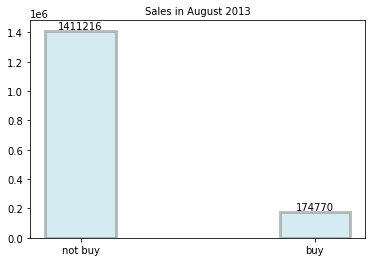

In [21]:
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

In [22]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40096282958984 MB
测试集使用内存 24.200225830078125 MB


### 内存优化脚本

In [23]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [24]:
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 349.8006982803345 MB
测试集使用内存 24.200225830078125 MB


# 构造时间滑窗特征

In [25]:
# 将用户下单金额按天进行汇总
# df = train[train.order_status<101][train.order_pay_time>'2013-02-01']
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

In [26]:
len(df_payment['customer_id'].unique())

685471

In [27]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [28]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)

### 每日购买商品数量

In [29]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

In [30]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

1. 构造dataset这里有个取巧的地方，因为要预测的9月份除了开学季以外不是非常特殊的月份，因此主要考虑近期的因素，数据集的开始时间也是2月1日，尽量避免了双十一、元旦假期的影响，当然春节假期继续保留。同时，构造数据集的时候保留了customer_id，主要为了与其它特征做整合。
2. 通过一个函数整合付款金额和商品数量的时间滑窗，主要是因为分开做到时候合并占用内存更大，并且函数最后在返回值处做了内存优化，用时间代价尽可能避免内存溢出。

In [31]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [32]:
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size
Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size
Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size
Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


In [33]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


### 中间结果保存

In [34]:
X_train.to_csv('X_train.csv')

In [35]:
X_test.to_csv('X_test.csv')

# 训练&推理 - 训练配置以及训练
加载特征工程结果

In [36]:
# X_train = pd.read_csv('X_train.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49','label'])
X_train = pd.read_csv('X_train.csv')
X_train.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [1]:
X_val = pd.read_csv('X_val.csv')
X_val.drop('Unnamed: 0', inplace=True, axis=1)

In [39]:
X_test = pd.read_csv('X_test.csv')
# X_test = pd.read_csv('X_test.csv',usecols=['max_30','has_sales_days_in_last_30','first_has_sales_day_in_last_60','goods_sum_49'])
X_test.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [40]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537,39.9,39.9,3.537,39.9,39.9,3.537,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000,0.0,0.0,2.530,98.9,197.8,2.530,...,1,37,37,2,37,56,0,2,0,1.0


# 选取参与训练的特征

In [43]:
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

In [2]:
X_train = X_train[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018','label']]
X_test = X_test[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018']]

In [3]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# 数据归一化

In [4]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [47]:
# 前面标签也被归一化了，还原
X_train['label'][X_train['label'] > 0] = 1

In [48]:
print(len(X_train.columns))

66


In [49]:
# 数据分割
def load_data(df,istrain):
    # data = np.fromfile(datafile)
    data = df

    feature_num = len(data.columns)
    # 将原始数据进行Reshape
    data = np.array(data)
    data = data.reshape([-1, feature_num])
    
    # 训练集和测试集的划分比例
    #ratio = 0.8
    if istrain == True:
        ratio = 0.8
        offset = int(data.shape[0] * ratio)
        training_data = data[:offset]
        test_data = data[offset:]
    else:
        training_data = data
        test_data = None

    return training_data, test_data

In [5]:
# 加载处理后的数据
training_data, test_data = load_data(X_train,True)
print('train set done.')

pre_data, none = load_data(X_test,False)
print('test set done.')

In [51]:
# 构建多层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x

In [7]:
with fluid.dygraph.guard():
    # 声明定义好的线性回归模型
    model = Regressor("Regressor")
    # 开启模型训练模式
    model.train()
    # 定义优化算法，这里使用Adam Optimizer
    # 学习率设置为0.00001
    opt = fluid.optimizer.Adam(learning_rate=0.00001, parameter_list=model.parameters())

In [ ]:
# 

In [53]:
# 使用类别权重对数据不平衡问题进行处理
def wce_loss(pred, label, w=48, epsilon=1e-05): # w 是给到 y=1 类别的权重，越大越重视
    label = fluid.layers.clip(label, epsilon, 1-epsilon)
    pred = fluid.layers.clip(pred, epsilon, 1-epsilon)

    loss = -1 * (w * label * fluid.layers.log(pred) + (1 - label) * fluid.layers.log(1 - pred))
    loss = fluid.layers.reduce_mean(loss)
    return loss

In [8]:
# 模型训练和保存
with dygraph.guard(fluid.CPUPlace()):
    EPOCH_NUM = 10   # 设置外层循环次数
    BATCH_SIZE = 4096  # 设置batch大小
    
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签

            # 将numpy数据转为飞桨动态图variable形式
            buyer_features = dygraph.to_variable(x)
            result = dygraph.to_variable(y)
            
            # 前向计算
            predicts = model(buyer_features)
            # loss = fluid.layers.log_loss(predicts, prices)
            loss = wce_loss(predicts, result)
            avg_loss = fluid.layers.mean(loss)
            
            logloss = fluid.layers.log_loss(predicts, prices)

            if iter_id % 20 == 0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
                # print(predicts)
     
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'MLP_model')
    print("模型保存成功，模型参数保存在MLP_model中")

In [9]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model_dict, _ = fluid.load_dygraph('MLP_model')
    model.load_dict(model_dict)
    model.eval()
    pre = pre_data.astype('float32')
    # 将数据转为动态图的variable格式
    pre = dygraph.to_variable(pre)
    results = model(pre)

    print("Inference result is {}".format(results.numpy()[:5]))

In [10]:
print(len(results))

In [11]:
results.numpy().flatten()[:6]

In [ ]:
sub = pd.read_csv('X_test.csv', usecols=['customer_id'])

In [12]:
df_preds = pd.DataFrame(
{    "customer_id": sub.customer_id, 
    "pred": results.numpy().flatten()}
)

In [13]:
df_preds.head()

In [ ]:
sub = pd.read_csv('submission.csv')

In [ ]:
sub.info()

In [ ]:
submission = pd.merge(sub, df_preds, on='customer_id', how='left')
submission.fillna(0,inplace=True)
submission = submission[['customer_id','pred']]
submission.rename(columns={'customer_id':'customer_id','pred':'result'}, inplace=True)

In [ ]:
submission.head()

In [ ]:
# 将概率值转换为用户是否购买的标签
def f(x):
    if x <= 0.5:
        return 0
    if x > 0.5:
        return 1
    return x

In [ ]:
submission['result'] = submission['result'].map(f)

In [ ]:
submission.to_csv('submission.csv',index=False)